## Import Necessary Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import kagglehub

# general setting. do not change TEST_SIZE
RANDOM_SEED = 42
TEST_SIZE = 0.3

## Load Dataset & Prepare Data

In [2]:
# load dataset（from kagglehub）
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data['Class'] = data['Class'].astype(int)

# prepare data
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

## Fraud/Non-Fraud Transactions

In [3]:
fraud = data[data['Class'] == 1]
nonfraud = data[data['Class'] == 0]
print(f'Fraudulent:{len(fraud)}, non-fraudulent:{len(nonfraud)}')
print(f'the positive class (frauds) percentage: {len(fraud)}/{len(fraud) + len(nonfraud)} ({len(fraud)/(len(fraud) + len(nonfraud))*100:.3f}%)')

Fraudulent:492, non-fraudulent:284315
the positive class (frauds) percentage: 492/284807 (0.173%)


In [4]:
# 特徵與標籤
X = data.drop(columns=['Class'])
y = data['Class']

# 資料分割（保持類別分布）
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## 非監督：Isolation Forest

In [5]:
iso_model = IsolationForest(contamination=0.0017, random_state=RANDOM_SEED, n_estimators=100)
iso_model.fit(x_train)

# 將異常分數轉成新特徵加入原資料
train_scores = iso_model.decision_function(x_train)
test_scores = iso_model.decision_function(x_test)

# 將 isolation score 當作新特徵加到原始特徵中
x_train['iso_score'] = train_scores
x_test['iso_score'] = test_scores

## 監督：XGBoost

In [6]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=RANDOM_SEED
)

xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [7]:
# define evaluation function
def evaluation(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'\n{model_name} Evaluation:')
    print('===' * 15)
    print('         Accuracy:', accuracy)
    print('  Precision Score:', precision)
    print('     Recall Score:', recall)
    print('         F1 Score:', f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [8]:
y_pred = xgb.predict(x_test)

evaluation(y_test, y_pred, model_name="XGBoost + Isolation Forest")


XGBoost + Isolation Forest Evaluation:
         Accuracy: 0.9994850368081645
  Precision Score: 0.9482758620689655
     Recall Score: 0.7432432432432432
         F1 Score: 0.8333333333333334

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.74      0.83       148

    accuracy                           1.00     85443
   macro avg       0.97      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



## 調整參數

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [10]:
iso_params = {
    'contamination': 0.0017, 
    'random_state': RANDOM_SEED, 
    'n_estimators': 200
}

In [11]:
xgb_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 5,
    'random_state': RANDOM_SEED
}

In [12]:
def training(iso_param, xgb_params, x_train, x_test, y_train, y_test):
  
    iso_model = IsolationForest(**iso_param)
    iso_model.fit(x_train)

    x_train = x_train.copy()
    x_test = x_test.copy()
    
    x_train['iso_score'] = iso_model.decision_function(x_train)
    x_test['iso_score'] = iso_model.decision_function(x_test)

    xgb = XGBClassifier(**xgb_params)
    xgb.fit(x_train, y_train)

    y_pred = xgb.predict(x_test)

    return f1_score(y_test, y_pred)

In [13]:
def tune_iso_param(param_name, param_values, iso_params, xgb_params, x_train, x_test, y_train, y_test, title=None):
    res = []

    for val in param_values:
        iso_param = iso_params.copy()
        iso_param[param_name] = val

        score = training(iso_param, xgb_params, x_train.copy(), x_test.copy(), y_train, y_test)
        res.append(score)

    best_idx = res.index(max(res))
    best_value = param_values[best_idx]
    best_score = res[best_idx]

    print(f"Best {param_name}: {best_value}, Best score: {best_score:.4f}")

    # 繪圖
    plt.figure(figsize=(12, 4))
    x_vals = [str(v) for v in param_values]
    plt.plot(x_vals, res, marker='o')
    plt.xlabel(param_name)
    plt.ylabel("Test F1 Score")
    plt.title(title if title else f"Tuning {param_name}")
    plt.grid(True)
    plt.show()

    return best_value, best_score

### contamination

Best contamination: 0.002, Best score: 0.8346


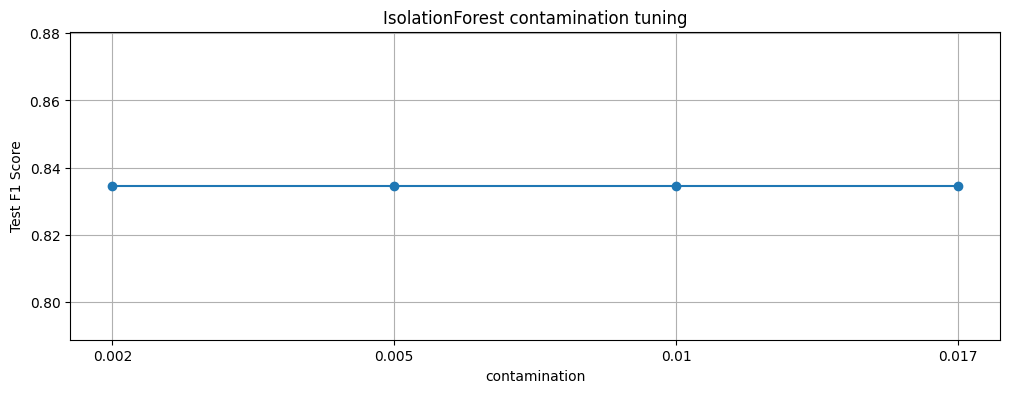

In [14]:
param_range = [0.002, 0.005, 0.01, 0.017]

best_val, best_score = tune_iso_param(
    param_name="contamination",
    param_values=param_range,
    iso_params=iso_params,
    xgb_params=xgb_params,
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    title="IsolationForest contamination tuning"
)

iso_params['contamination'] = best_val

### n_estimators

Best n_estimators: 250, Best score: 0.8377


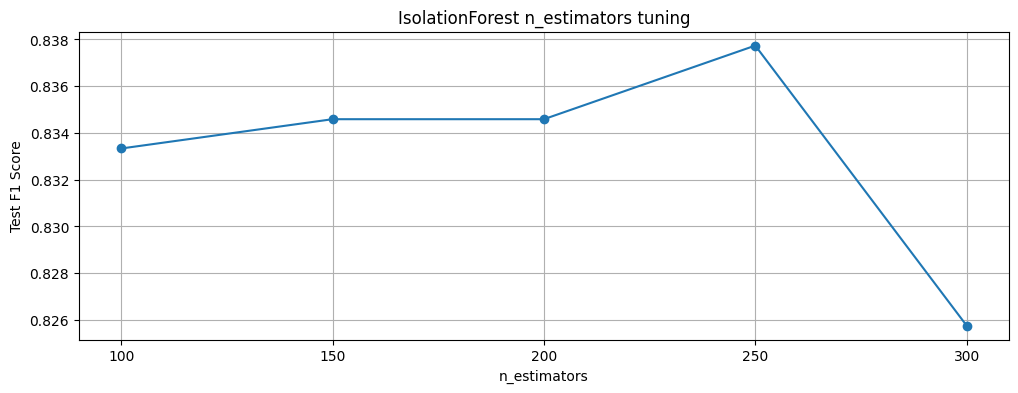

In [15]:
param_range = list(range(100, 301, 50))

best_val, best_score = tune_iso_param(
    param_name="n_estimators",
    param_values=param_range,
    iso_params=iso_params,
    xgb_params=xgb_params,
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    title="IsolationForest n_estimators tuning"
)

iso_params['n_estimators'] = best_val

### 實際測試

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

iso_model = IsolationForest(**iso_params)
iso_model.fit(x_train)

train_scores = iso_model.decision_function(x_train)
test_scores = iso_model.decision_function(x_test)

x_train['iso_score'] = train_scores
x_test['iso_score'] = test_scores

xgb = XGBClassifier(**xgb_params)
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)
evaluation(y_test, y_pred, model_name="XGBoost + Isolation Forest")


XGBoost + Isolation Forest Evaluation:
         Accuracy: 0.9994967405170698
  Precision Score: 0.9487179487179487
     Recall Score: 0.75
         F1 Score: 0.8377358490566038

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.75      0.84       148

    accuracy                           1.00     85443
   macro avg       0.97      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



### XGBoost

In [17]:
def tune_xgb_param(param_name, param_values, iso_params, xgb_params , x_train, x_test, y_train, y_test, title=None):
    res = []

    for val in param_values:
        xgb_param = xgb_params.copy()
        xgb_param[param_name] = val

        score = training(iso_params, xgb_param, x_train.copy(), x_test.copy(), y_train, y_test)
        res.append(score)

    best_idx = res.index(max(res))
    best_value = param_values[best_idx]
    best_score = res[best_idx]

    print(f"Best {param_name}: {best_value}, Best Test F1 score: {best_score:.4f}")

    # 繪圖
    plt.figure(figsize=(12, 4))
    x_vals = [str(v) for v in param_values]
    plt.plot(x_vals, res, marker='o')
    plt.xlabel(param_name)
    plt.ylabel("Test F1 Score")
    plt.title(title if title else f"Tuning {param_name}")
    plt.grid(True)
    plt.show()

    return best_value, best_score

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [19]:
nonfraud_count_train = np.sum(y_train == 0)
fraud_count_train = np.sum(y_train == 1)
scale_pos_weight_val = nonfraud_count_train / fraud_count_train

xgb_params = {
    'n_estimators': 200, 
    'learning_rate': 0.05,
    'max_depth': 5,
    'random_state': RANDOM_SEED,
    'eval_metric': 'aucpr',
    'scale_pos_weight': scale_pos_weight_val
}

In [20]:
print(iso_params)
print(xgb_params)

{'contamination': 0.002, 'random_state': 42, 'n_estimators': 250}
{'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'random_state': 42, 'eval_metric': 'aucpr', 'scale_pos_weight': 578.546511627907}


### n_estimators

Best n_estimators: 400, Best Test F1 score: 0.8127


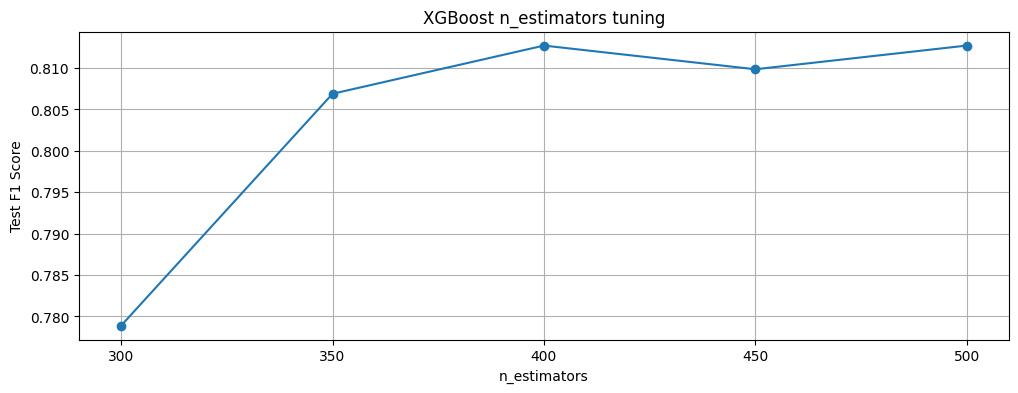

In [21]:
param_range = list(range(300, 501, 50))

best_val, best_score = tune_xgb_param(
    param_name="n_estimators",
    param_values=param_range,
    iso_params=iso_params,
    xgb_params=xgb_params,
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    title="XGBoost n_estimators tuning"
)

xgb_params['n_estimators'] = best_val

### learning_rate

Best learning_rate: 0.1, Best Test F1 score: 0.8345


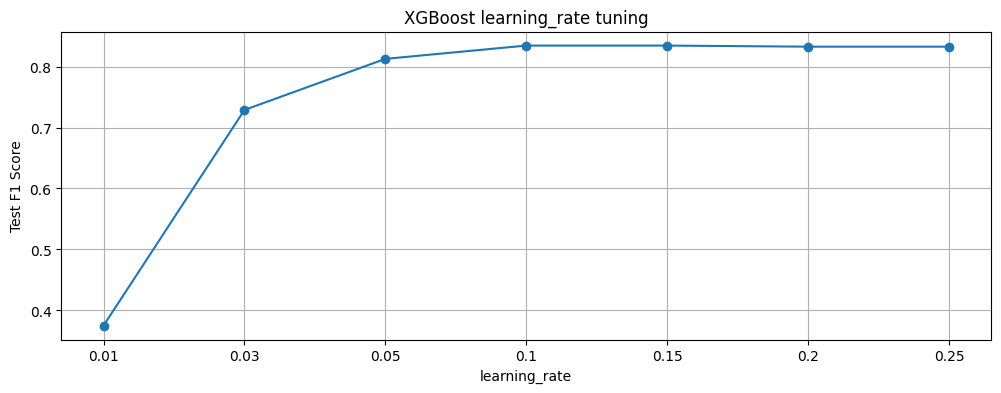

xgb_params (learning_rate 調參後): {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 42, 'eval_metric': 'aucpr', 'scale_pos_weight': 578.546511627907}


In [22]:
param_range_lr = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25]

best_val_lr, best_score_lr = tune_xgb_param(
    param_name="learning_rate",
    param_values=param_range_lr,
    iso_params=iso_params,
    xgb_params=xgb_params,
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    title="XGBoost learning_rate tuning"
)
xgb_params['learning_rate'] = best_val_lr
print("xgb_params (learning_rate 調參後):", xgb_params)

### max_depth

Best max_depth: 8, Best Test F1 score: 0.8520


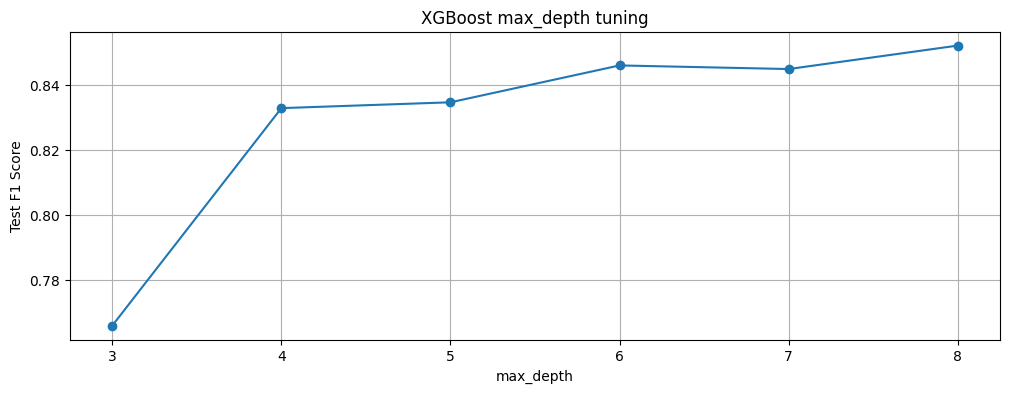

xgb_params (max_depth 調參後): {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'random_state': 42, 'eval_metric': 'aucpr', 'scale_pos_weight': 578.546511627907}


In [23]:
param_range_md = [3, 4, 5, 6, 7, 8]

best_val_md, best_score_md = tune_xgb_param(
    param_name="max_depth",
    param_values=param_range_md,
    iso_params=iso_params,
    xgb_params=xgb_params,
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    title="XGBoost max_depth tuning"
)
xgb_params['max_depth'] = best_val_md
print("xgb_params (max_depth 調參後):", xgb_params)

### Tune subsample

Best subsample: 1.0, Best Test F1 score: 0.8520


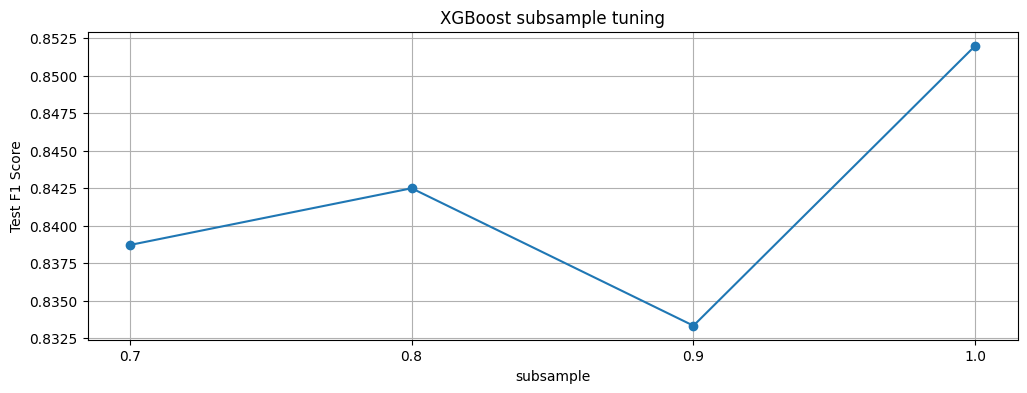

xgb_params (after subsample tuning): {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'random_state': 42, 'eval_metric': 'aucpr', 'scale_pos_weight': 578.546511627907, 'subsample': 1.0}


In [24]:
param_range_subsample = [0.7, 0.8, 0.9, 1.0]
best_val_sub, _ = tune_xgb_param(
    param_name="subsample",
    param_values=param_range_subsample,
    iso_params=iso_params,
    xgb_params=xgb_params,
    x_train=x_train, 
    x_test=x_test,   
    y_train=y_train,
    y_test=y_test,
    title="XGBoost subsample tuning"
)
xgb_params['subsample'] = best_val_sub
print("xgb_params (after subsample tuning):", xgb_params)

### colsample_bytree

Best colsample_bytree: 1.0, Best Test F1 score: 0.8520


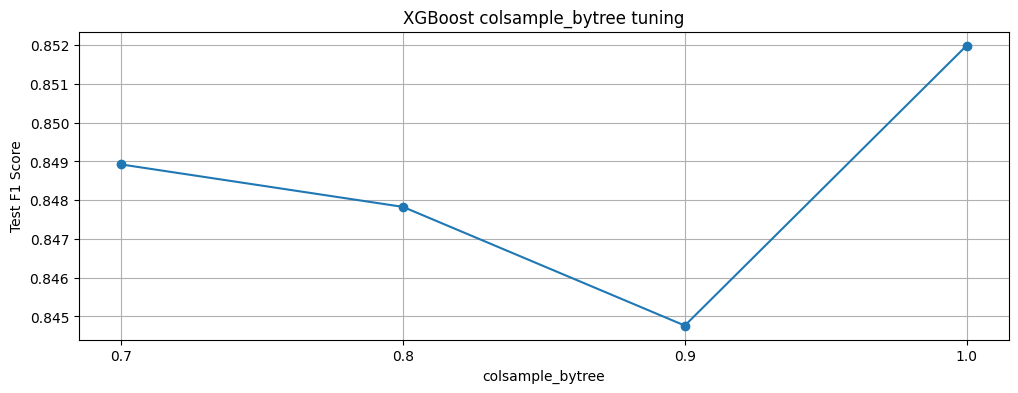

xgb_params (after colsample_bytree tuning): {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'random_state': 42, 'eval_metric': 'aucpr', 'scale_pos_weight': 578.546511627907, 'subsample': 1.0, 'colsample_bytree': 1.0}


In [25]:
param_range_colsample = [0.7, 0.8, 0.9, 1.0]
best_val_col, _ = tune_xgb_param(
    param_name="colsample_bytree",
    param_values=param_range_colsample,
    iso_params=iso_params,
    xgb_params=xgb_params,
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    title="XGBoost colsample_bytree tuning"
)
xgb_params['colsample_bytree'] = best_val_col
print("xgb_params (after colsample_bytree tuning):", xgb_params)

### gamma

Best gamma: 0, Best Test F1 score: 0.8520


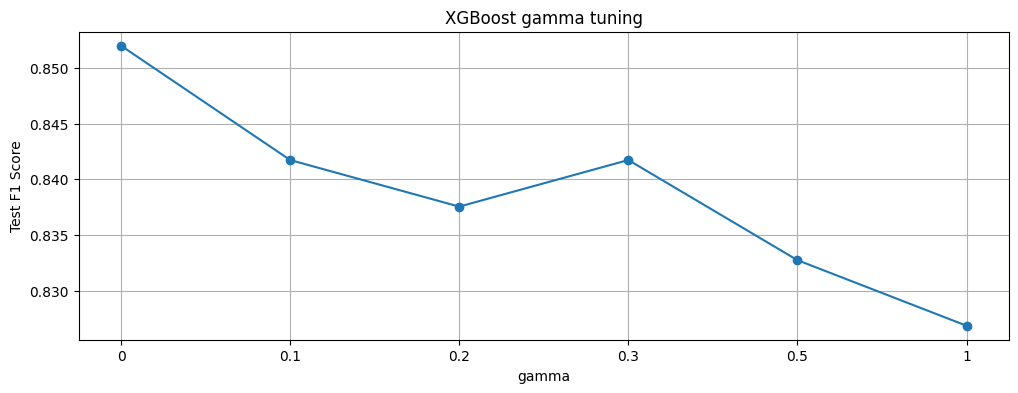

xgb_params (after gamma tuning): {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'random_state': 42, 'eval_metric': 'aucpr', 'scale_pos_weight': 578.546511627907, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0}


In [26]:
param_range_gamma = [0, 0.1, 0.2, 0.3, 0.5, 1]
best_val_gamma, _ = tune_xgb_param(
    param_name="gamma",
    param_values=param_range_gamma,
    iso_params=iso_params,
    xgb_params=xgb_params,
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    title="XGBoost gamma tuning"
)
xgb_params['gamma'] = best_val_gamma
print("xgb_params (after gamma tuning):", xgb_params)

## 實際測試

In [27]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

iso_model = IsolationForest(**iso_params)
iso_model.fit(x_train)

train_scores = iso_model.decision_function(x_train)
test_scores = iso_model.decision_function(x_test)

x_train['iso_score'] = train_scores
x_test['iso_score'] = test_scores

xgb = XGBClassifier(**xgb_params)
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)
evaluation(y_test, y_pred, model_name="XGBoost + Isolation Forest")


XGBoost + Isolation Forest Evaluation:
         Accuracy: 0.9995201479348805
  Precision Score: 0.9147286821705426
     Recall Score: 0.7972972972972973
         F1 Score: 0.851985559566787

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.80      0.85       148

    accuracy                           1.00     85443
   macro avg       0.96      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



## Final

In [28]:
final_iso_params = iso_params.copy()
final_xgb_params = xgb_params.copy()

print(final_iso_params)
print(final_xgb_params)

{'contamination': 0.002, 'random_state': 42, 'n_estimators': 250}
{'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'random_state': 42, 'eval_metric': 'aucpr', 'scale_pos_weight': 578.546511627907, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0}


In [29]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

iso_model = IsolationForest(**final_iso_params)
iso_model.fit(x_train)

train_scores = iso_model.decision_function(x_train)
test_scores = iso_model.decision_function(x_test)

x_train['iso_score'] = train_scores
x_test['iso_score'] = test_scores

xgb = XGBClassifier(**final_xgb_params)
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)
evaluation(y_test, y_pred, model_name="XGBoost + Isolation Forest")


XGBoost + Isolation Forest Evaluation:
         Accuracy: 0.9995201479348805
  Precision Score: 0.9147286821705426
     Recall Score: 0.7972972972972973
         F1 Score: 0.851985559566787

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.80      0.85       148

    accuracy                           1.00     85443
   macro avg       0.96      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443

